In [15]:
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Download datset

In [16]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.MNIST(root="data", train=True, transform=ToTensor(), download=True)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())

In [6]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [11]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


## Visualization of dataset

In [17]:
import matplotlib.pyplot as plt

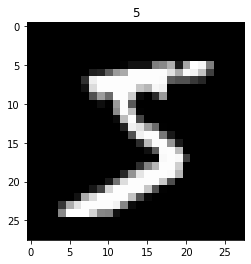

In [19]:
plt.imshow(train_data.data[0], cmap="gray")
plt.title("%i" % train_data.targets[0])
plt.show()

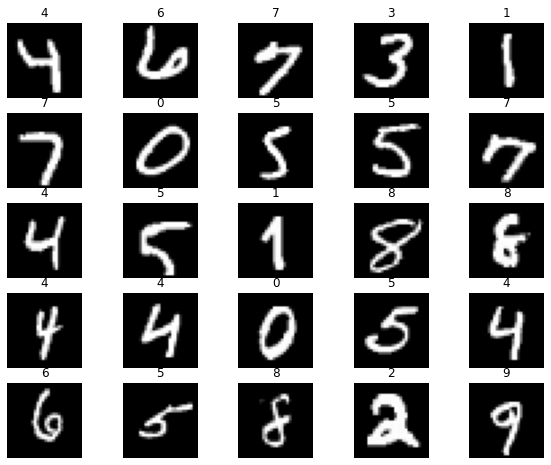

In [43]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Prepare data with DataLoaders

In [44]:
from torch.utils.data import DataLoader

In [45]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fcea62d29a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fcea62d2be0>}

## Define the Network

In [46]:
import torch.nn as nn

In [123]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    
        
    def forward(self, x):
        print(x.size())
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [124]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [52]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [53]:
from torch import optim

In [54]:
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

## Train the model

In [126]:
from torch.autograd import Variable

In [56]:
num_epochs = 10

In [60]:
def train(num_epochs, cnn, loaders):

    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               

In [ ]:
train(num_epochs, cnn, loaders)

## Evaluate the model

In [102]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        total_correct = 0
        total_count = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct = (pred_y == labels).sum().item()
            count = len(labels)
            total_correct += correct
            total_count += count
    accuracy = total_correct / total_count
    print("Total: {0}, Correct: {1}".format(total_count, total_correct))
    print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)

In [103]:
test()

Total: 10000, Correct: 9829
Test Accuracy of the model on the 10000 test images: 0.9829


In [106]:
sample = next(iter(loaders['test']))
images, labels = sample

In [107]:
actual_number = labels[:10].numpy()
actual_number

array([9, 2, 3, 7, 8, 2, 8, 1, 9, 3])

In [110]:
test_output, last_layer = cnn(images[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction: {pred_y}')
print(f'Actual    : {actual_number}')

Prediction: [9 2 3 7 8 2 8 1 9 3]
Actual    : [9 2 3 7 8 2 8 1 9 3]
